### Importando os dados MNIST

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

#### Conferindo informações do mnist

Separando em atributos previsores e atributos alvo

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

### Vizualizando um número do mnist

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

(-0.5, 27.5, 27.5, -0.5)

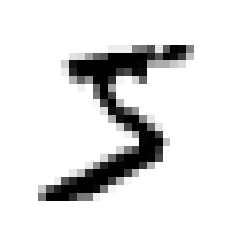

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")

Como o y está como string, precisamos converte-lo para inteiro

In [8]:
import numpy as np
y = y.astype(np.uint8)

### Separando em conjunto de treino e teste

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Primeiramente será construido um classificador binário, com o objetivo de identificar o número 5

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

##### Para isso será utilizad o SGDclassifier

importando o SGD pelo scikit learning

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

#### Avaliando o modelo por meio da validação cruzada

In [12]:
from sklearn.model_selection import cross_val_score

Dividindo o cojunto de treinamento em 3 folds e avaliando o desempenho por accuracy

In [13]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

O resultado da acurácia foi muito alto, pois as classes são desbalancedas

#### Avaliando o modelo por matriz de confusão

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

#### Avaliando precison, recall e f1-score do classificador

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [17]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Usando o método decision.function() para avaliar o score de cada instância 

O predição é feita com base nesse score usando um liminar desejado

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

O SGD usa o limiar igual a 0, mas podemos aumentar esse limiar, com o objetivo de diminuir a revocação

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Para avaliar qual seria o melhor valor para o threshold, podemos usar a função cross_val_predict, passando decision_function como parametro para method

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Com esse valor de score, podemos usar a função precision_recall_curve para calcularmos a precisão e revocação para todos os thresholds

In [65]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Função para plotar os valores de precision e recall dado o limiar

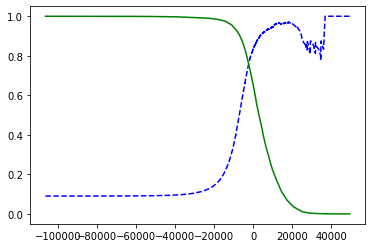

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### CURVA ROC

#### A curva ROC representa a taxa de verdadeiros positivos em relação à taxa de falsos positivos

Inicialmente usamos a função roc_curve() para calcularmos o TPR e o FPR

In [66]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Funçaõ para plotar a ROC curve

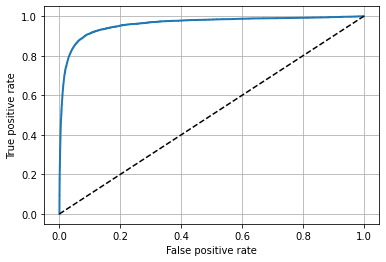

In [67]:
def plot_roc_curve(fprr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

#### Outra forma de avaliar o classificador, é observar área sob a curva ROC (AUC)

Um classificador perfeito terá AUC igual a 1, enquanto um classificador aleatório terá AUC igual a 0.5

In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Agora iremos treinar um RandomForestClassifier e comparar sua curva roc e o AUC com as do SGDclassifier

O RandomForest não possui decion_function(), entretanto possui predict_proba(), que retorna um array que contém uma linha por instância e uma coluna por classe, cada uma com a probabilidad de que a instâcia pertença à classe especificada.

In [69]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Usaremos a probabilidde de classe para plotar a curva ROC

In [73]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

ValueError: x and y must have same first dimension, but have shapes (3908,) and (101,)

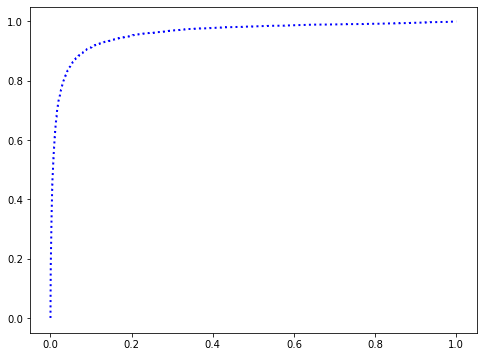

In [78]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [79]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Classificação Multiclasse

### OvR vs OvO

Ovr: Treinar um classificador binário para cada classe

OvO: Treinar um classficador binário para cada par de classe

### Usando SVM como classificador

In [82]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

Sklearn usou a estrategia OvO, podemos ver no decision_function que retorna 10 scores por instância

In [83]:
some_digit_scores = svm_clf.decision_function([some_digit])
np.argmax(some_digit_scores)

5

Podemos forçar o sklearn a usar a estrategia OvR:

In [84]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

Podemos treinar um SGDclassifier, que podem classificar diretamente as instâncias em várias classes

In [86]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

Observando o resultado com cross val

In [87]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Para melhor o resultado podemos fazer o escalonamento das entradas com StandardScaler

In [89]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [91]:
cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

array([3, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Análise de erro

Para analisar os erros do projeto, podemos analisar a matriz de con

In [92]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [94]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

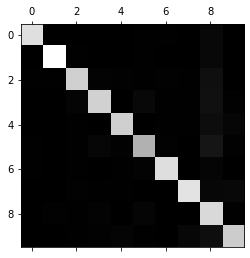

In [95]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

Divindo cada valor da matriz de confusão pelo número de imagens na calsse correspondente, para comparar as taxas de erros e nao os valores absolutos de erros

In [96]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

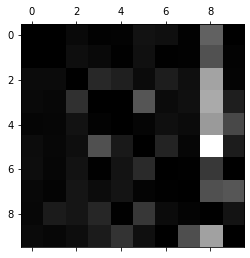

In [97]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Classificação multirrótulo

#### Classificador irá atribuir dois rotulos-alvo para cada imagem. O primeiro indica se o numero é grande (7, 8, 9) e o segundo indica se o numero é impar ou nao.

Determinando as duas classes, y_train_large e y_train_odd

In [100]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

Usando um clasificador KNN

In [103]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [104]:
knn_clf.predict([some_digit])

array([[False,  True]])

Avaliando o classificador

In [107]:
y_train_prd = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_prd, average='macro')

0.976410265560605